[Looking at someone's code on kaggle](https://www.kaggle.com/asindico/a-japanese-journey/comments)

In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
from mapboxgl.viz import *
from mapboxgl.utils import *

In [3]:
# Must be a public token, starting with `pk`
token = 'pk.eyJ1IjoiYW5kZTg2MDkiLCJhIjoiY2psbzNmbjN2MXBrYjNrb3M0ZnpwNXM5biJ9.ap0AV9slM0h57R-A7Qsq4w'

# Thoughts
- I want to get a shapefile for Japan and plot out where all of the restaraunts in the dataset are in the country.

# Data Wrangling

In [58]:
# This has the number of visitors that had a reservation
airres = pd.read_csv('air_reserve.csv')
# This has all of the basic information about each store
airstore = pd.read_csv('air_store_info.csv')
# This is the number of visitors that made reservations
hpgres1 = pd.read_csv('hpg_reserve_1.csv')
hpgres2 = pd.read_csv('hpg_reserve_2.csv', names=hpgres1.columns)
# The hpg_reserve.csv file got split mid-line, this fixes that line
hpgres1.iloc[-1,0] += hpgres2.iloc[0,0]
hpgres1.iloc[-1,1:] = hpgres2.iloc[0,1:]
# Throwing all the hpg_reserve data into a single dataframe
hpgres = pd.concat([hpgres1, hpgres2.iloc[1:,:]], ignore_index=True)
del hpgres1, hpgres2
# This has basic information
hpgstore = pd.read_csv('hpg_store_info.csv')
# This is where the visitor data lives
airvisit = pd.read_csv('air_visit_data.csv')

In [59]:
air = pd.merge(airres, airstore, on='air_store_id')
hpg = pd.merge(hpgres, hpgstore, on='hpg_store_id')
rel = pd.read_csv('store_id_relation.csv')
airrel = pd.merge(air, rel, how='left', on='air_store_id')
hpgrel = pd.merge(hpg, rel, how='left', on='hpg_store_id')
full = pd.merge(airrel, hpgrel, how='outer')

In [60]:
full['visit_datetime'] = pd.to_datetime(full.visit_datetime)
full['reserve_datetime'] = pd.to_datetime(full.reserve_datetime)
full['visit_weekday'] = full.visit_datetime.dt.weekday_name
full['visit_dayofweek'] = full.visit_datetime.dt.dayofweek
full['reserve_weekday'] = full.reserve_datetime.dt.weekday_name
full['reserve_dayofweek'] = full.reserve_datetime.dt.dayofweek

In [61]:
from sklearn.cluster import KMeans

In [62]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(full[['longitude', 'latitude']])
full['cluster'] = kmeans.predict(full[['longitude', 'latitude']])

### Looking at a sample of the dataset

In [33]:
_testdf = full.sample(10000, axis=0)

In [34]:
_testdf['time_diff'] = _testdf.visit_datetime - _testdf.reserve_datetime

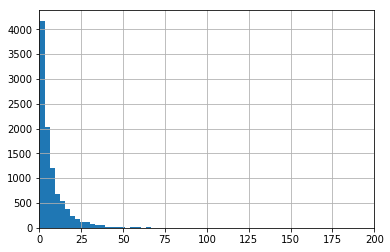

In [12]:
(_testdf.time_diff / pd.Timedelta(days=1)).hist(bins=100)
plt.xlim(0, 200)
None

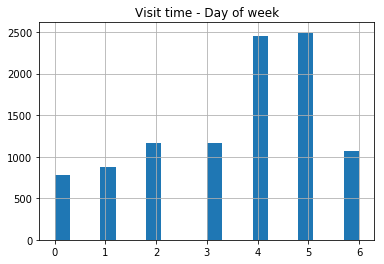

In [13]:
_testdf.visit_dayofweek.hist(bins=20)
plt.title('Visit time - Day of week')
None

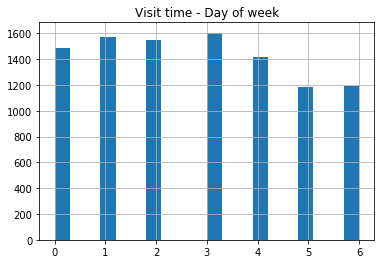

In [14]:
_testdf.reserve_dayofweek.hist(bins=20)
plt.title('Visit time - Day of week')
None

In [16]:
len(full.air_store_id.unique())

321

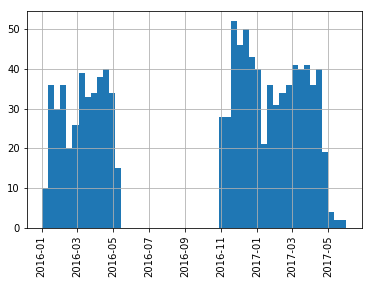

In [17]:
full[full.air_store_id == 'air_877f79706adbfb06'].visit_datetime.hist(bins=50)
plt.xticks(rotation=90)
None

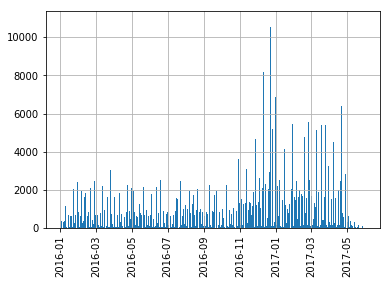

In [18]:
full.visit_datetime.hist(bins=1000)
plt.xticks(rotation=90)
#plt.xlim([datetime.date(2016, 1, 26), datetime.date(2016, 2, 1)])
None

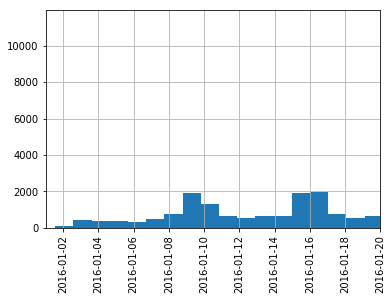

In [19]:
full.visit_datetime.hist(bins=500)
plt.xticks(rotation=90)
plt.xlim([datetime.date(2016, 1, 1), datetime.date(2016, 1, 20)])
None

In [21]:
_testdf.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,visit_weekday,visit_dayofweek,reserve_weekday,reserve_dayofweek,time_diff
794960,NaN,2017-03-24 19:00:00,2017-03-14 17:00:00,6,NaN,NaN,41.786764,140.743511,hpg_3a2ee77446acdda5,Seafood,Hokkaidō Hakodate-shi None,Friday,4,Tuesday,1,10 days 02:00:00
569641,NaN,2016-01-28 19:00:00,2016-01-15 14:00:00,5,NaN,NaN,35.670728,139.824576,hpg_b1f3a072d9569fa2,Japanese style,Tōkyō-to Kōtō-ku Minamisuna,Thursday,3,Friday,4,13 days 05:00:00
887478,NaN,2016-12-10 18:00:00,2016-11-22 14:00:00,22,NaN,NaN,35.624533,139.421325,hpg_6beb34c652a733f1,Japanese style,Tōkyō-to Tama-shi Tsurumaki,Saturday,5,Tuesday,1,18 days 04:00:00
802413,NaN,2016-05-06 20:00:00,2016-05-03 00:00:00,3,NaN,NaN,35.659214,139.699736,hpg_c036cc6c840fc48e,Spain Bar/Italian Bar,Tōkyō-to Shibuya-ku None,Friday,4,Tuesday,1,3 days 20:00:00
288478,NaN,2016-06-21 19:00:00,2016-06-21 10:00:00,5,NaN,NaN,34.692109,135.191698,hpg_f471399a915306fb,Chinese general,Hyōgo-ken Kōbe-shi None,Tuesday,1,Tuesday,1,0 days 09:00:00


In [35]:
data = df_to_geojson(_testdf.fillna(''),
                     properties=['hpg_genre_name', 'hpg_area_name', 'air_area_name', 'air_genre_name', 'reserve_visitors', 'cluster'],
                     precision=4,
                     lat='latitude',
                     lon='longitude')

In [23]:
type(data)

geojson.feature.FeatureCollection

In [24]:
data.keys()

dict_keys(['type', 'features'])

In [25]:
data['features'][0]['properties']

{'hpg_genre_name': 'Seafood',
 'hpg_area_name': 'Hokkaidō Hakodate-shi None',
 'air_area_name': '',
 'air_genre_name': '',
 'reserve_visitors': 6}

In [ ]:
color_breaks = list(range(9))
color_stops = create_color_stops(color_breaks, colors='YlGnBu')
# Initialize CircleViz with Categorical Measure Data
viz = CircleViz(data, 
                access_token=token,
                height='500px',
                label_property='cluster',
                color_property='cluster',
                color_stops=color_stops,
                radius=2,
                center=(137.5, 38),
                zoom=4,
                opacity=.1)

# Render map
viz.show() 

In [29]:
#color_breaks = 
color_stops = create_color_stops(color_breaks, colors='YlGnBu')
# Initialize CircleViz with Categorical Measure Data
viz = CircleViz(data, 
                access_token=token,
                height='500px',
                label_property='reserve_visitors',
                color_property='time_diff',
                #color_stops=color_stops,
                radius=2,
                center=(137.5, 38),
                zoom=4,
                opacity=.1)

# Render map
viz.show() 

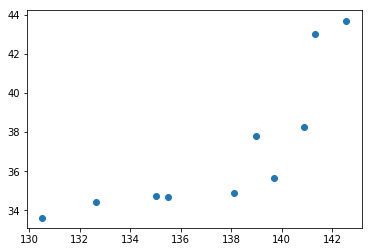

In [8]:
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])